# **Baseline Models with Word2Vec Vectorization**
# **CIS 5190 Group Project**
By 	Mona Gandhi, Jeffrey Li, Henil Satra <br>

# Imports/Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os
import re
import seaborn as sns
from tqdm import tqdm
import pickle


# preprocessing
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# classification
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [3]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk
From (redirected): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk&confirm=t&uuid=d905e956-f883-4706-83ae-00c2f60dbf4d
To: /content/Reviews.csv
100% 301M/301M [00:06<00:00, 46.7MB/s]


In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Loading


In [6]:
reviews_df = pd.read_csv('Reviews.csv')

In [7]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# Data Preparation

In [9]:
reviews_df = reviews_df[['Text', 'Score']]

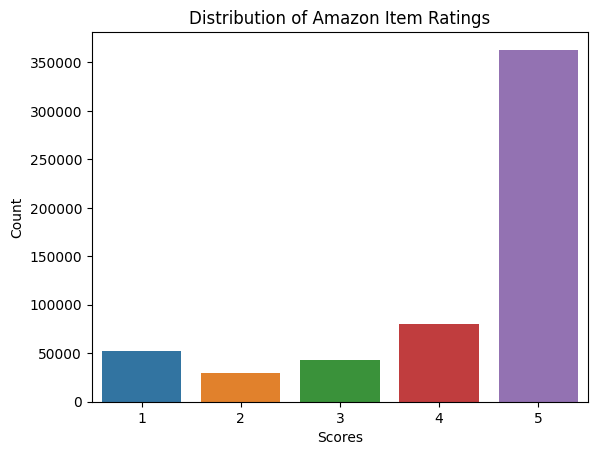

In [10]:
sns.countplot(x=reviews_df.Score)
plt.xlabel('Scores')
plt.ylabel("Count")
plt.title("Distribution of Amazon Item Ratings")
plt.show()

In [11]:
# create labels: "Positive" and "Negative"
reviews_df['Label'] = reviews_df['Score'].apply(lambda x: "Positive" if x > 3 else "Negative")

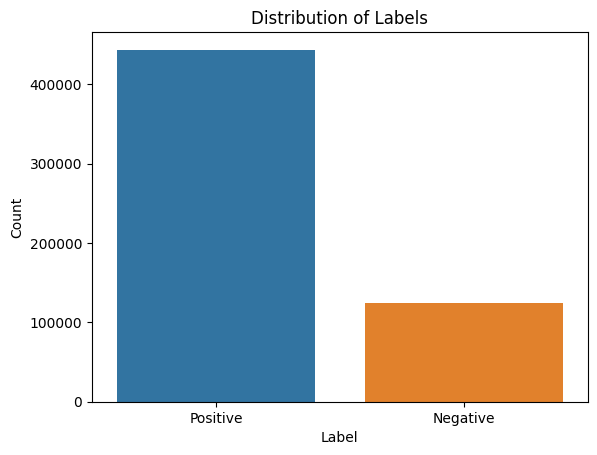

In [12]:
sns.countplot(x=reviews_df.Label)
plt.xlabel('Label')
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

# Data Preprocessing

In [13]:
reviews_df = reviews_df[reviews_df['Text'].notna()]

In [14]:
reviews_df = reviews_df[reviews_df['Text'].apply(lambda x: len(x.split()) != 0)]

In [15]:
NUMBERS_RE = re.compile('[^0-9]+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [16]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    result = re.match(r"[0-9]+", text)
    if result != None:
      text = NUMBERS_RE.sub('X', text)

    text = text.replace('X', '')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

reviews_df['Text'] = reviews_df['Text'].apply(clean_text)

In [17]:
reviews_df.head()

,Text,Score,Label
0,bought several vitality canned dog food produc...,5,Positive
1,product arrived labeled jumbo salted peanutsth...,1,Negative
2,confection around centuries light pillowy citr...,4,Positive
3,looking secret ingredient robitussin believe f...,2,Negative
4,great taffy great price wide assortment yummy ...,5,Positive


In [18]:
reviews_df.shape

(568454, 3)

## Train-Test Split

Since the pretrained word2vec model takes very long to get the average embedding, we create a balanced subset of the data. We will be carrying out all evaluations for word2vec on this exact subset. 

In [19]:
s0 = reviews_df.Label[reviews_df.Label.eq("Positive")].sample(5000).index
s1 = reviews_df.Label[reviews_df.Label.eq("Negative")].sample(5000).index 

reviews_df_sub = reviews_df.loc[s0.union(s1)]

In [20]:
reviews_df_sub['Label'].value_counts()

Positive    5000
Negative    5000
Name: Label, dtype: int64

In [21]:
reviews_sub_pos = reviews_df_sub[reviews_df_sub['Label']=='Positive']
reviews_sub_neg = reviews_df_sub[reviews_df_sub['Label']=='Negative']

In [22]:
X_pos = reviews_sub_pos['Text']
X_neg = reviews_sub_neg['Text']

In [23]:
y_pos = np.where(reviews_sub_pos['Label']=='Positive', 1, 0)
y_neg = np.where(reviews_sub_neg['Label']=='Positive', 1, 0)

In [24]:
import collections
collections.Counter(y_neg)

Counter({0: 5000})

In [25]:
# train test split 80:20
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=0.2, random_state = 42)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=0.2, random_state = 42)

In [26]:
X_train = pd.concat([X_train_pos, X_train_neg], axis=0)
y_train = np.concatenate([y_train_pos, y_train_neg], axis=0)
X_test = pd.concat([X_test_pos, X_test_neg], axis=0)
y_test = np.concatenate([y_test_pos, y_test_neg], axis=0)

In [27]:
import collections
collections.Counter(y_train)

Counter({1: 4000, 0: 4000})

In [ ]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'
np.save(f'{path}/X_train_large', X_train)
np.save(f'{path}/y_train_large', y_train)
np.save(f'{path}/X_test_large', X_test)
np.save(f'{path}/y_test_large', y_test)

#### To run everything, after imports just run from here!!

In [5]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'
X_train = np.load(f'{path}/X_train_large.npy', allow_pickle=True)
y_train = np.load(f'{path}/y_train_large.npy', allow_pickle=True)
X_test = np.load(f'{path}/X_test_large.npy', allow_pickle=True)
y_test = np.load(f'{path}/y_test_large.npy', allow_pickle=True)

In [6]:
import collections
print("Counter for y_train: ", collections.Counter(y_train))
print("Counter for y_train: ", collections.Counter(y_test))

Counter for y_train:  Counter({1: 4000, 0: 4000})
Counter for y_train:  Counter({1: 1000, 0: 1000})


In [7]:
def trunc_pad(sentences, max_len):
    trunc_padded_sentences = []
    for sentence in sentences:
        words = sentence.split()
        split_sent = words[:max_len]
        to_pad = max_len - len(split_sent)
        for i in range(to_pad):
            split_sent.append('<pad>') 
        trunc_padded_sentences.append(split_sent)
    return trunc_padded_sentences

In [ ]:
# print("MAX review length: ", X_train.apply(lambda x: len(x.split())).max())
# print("MIN review length: ", X_train.apply(lambda x: len(x.split())).min())
# print("MEAN review length: ", X_train.apply(lambda x: len(x.split())).mean())
# print("MODE review length: ", X_train.apply(lambda x: len(x.split())).mode())

MAX review length:  433
MIN review length:  1
MEAN review length:  41.00416666666667
MODE review length:  0    17
Name: Text, dtype: int64


In [8]:
# Trunc/Pad X_train and y_train
MAX_LEN = 50 # As the mean is 41
X_train_pad = trunc_pad(X_train, MAX_LEN)
X_test_pad = trunc_pad(X_test, MAX_LEN)

## Word2Vec Embeddings

In [9]:
import gensim.downloader as api

In [87]:
glove = 'glove-wiki-gigaword-300'
word2vec = 'fasttext-wiki-news-subwords-300'

#change appropriately!
# vector_type = glove
vector_type = word2vec

model = api.load(vector_type)

[=================================================-] 99.4% 952.6/958.4MB downloaded


In [88]:
class Vocabulary:
    def __init__(self, model):
        '''
        vocab: np.array
        '''
        self.model = model
        self.embed = model.vector_size
        self.vocab = model.index_to_key
        mean_vector = model.get_mean_vector(self.vocab)
        self.model.add_vector('<pad>', np.zeros((self.embed)))
        self.model.add_vector('<unk>', mean_vector)
        self.vocab = model.index_to_key
        self.size = len(self.vocab)

    def get_word_to_idx(self, word):
        if word not in self.vocab:
            word = '<unk>'
        return self.model.key_to_index[word]

    def get_embedding(self, word):
        if word not in self.vocab:
            word = '<unk>'
        return self.model[word]

In [89]:
vocab_class = Vocabulary(model)

/usr/local/lib/python3.9/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [90]:
def get_embedding_sentence(words, vocab):
    embedding_sentence = np.zeros((len(words), vocab.embed))
    for i, word in enumerate(words):
        embedding = vocab.get_embedding(word=word)
        embedding_sentence[i] = embedding
    return embedding_sentence

In [ ]:
sent_vectors_train = np.zeros((len(X_train_pad), MAX_LEN, vocab_class.embed))
i = 0
for sentence in tqdm(X_train_pad):
    sentence_vector = get_embedding_sentence(sentence, vocab_class)
    sent_vectors_train[i] = sentence_vector
    i += 1

In [ ]:
sent_vectors_test = np.zeros((len(X_test_pad), MAX_LEN, vocab_class.embed))
i = 0
for sentence in tqdm(X_test_pad):
    sentence_vector = get_embedding_sentence(sentence, vocab_class)
    sent_vectors_test[i] = sentence_vector
    i += 1

In [37]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'

# saving vertorized vectors
pickle.dump(sent_vectors_train, open(f"{path}/X_train_{vector_type}_large_300","wb"))
pickle.dump(sent_vectors_test, open(f"{path}/X_test_{vector_type}_large_300","wb"))

NameError: ignored

In [ ]:
# import torch
# my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

# assert my_embedding_layer.weight.shape == embs_npa.shape
# print(my_embedding_layer.weight.shape)

In [ ]:
# text = train_reviews[0]
# my_embedding_layer(text)

# Baseline Classification Models

#### In order to replicate our results, just run from here!

### Loading saved vectors for X_train and X_test

Remove comments to whichever version you are running

In [215]:
# w2v
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'
X_train = np.load(f'{path}/X_train_glove_large_300', allow_pickle=True)
y_train = np.load(f'{path}/y_train_large.npy', allow_pickle=True)
X_test = np.load(f'{path}/X_test_glove_large_300', allow_pickle=True)
y_test = np.load(f'{path}/y_test_large.npy', allow_pickle=True)

In [209]:
# # glove
# path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'
# X_train = np.load(f'{path}/X_train_glove_large_300', allow_pickle=True)
# y_train = np.load(f'{path}/y_train_large.npy', allow_pickle=True)
# X_test = np.load(f'{path}/X_test_glove_large_300', allow_pickle=True)
# y_test = np.load(f'{path}/y_test_large.npy', allow_pickle=True)

For Baselines, we need to take average of vectors for all words

In [216]:
X_train.shape

(8000, 50, 300)

In [217]:
X_train_avg = np.mean(X_train, axis=1)
X_test_avg = np.mean(X_test, axis=1)

In [218]:
X_train_avg.shape

(8000, 300)

### Naive Bayes

In [219]:
# naive bayes fit and predict
nb_clf_under = BernoulliNB().fit(X_train_avg, y_train) 
y_pred = nb_clf_under.predict(X_test_avg)

In [220]:
# model accuracy
nb_acc = accuracy_score(y_test, y_pred)
nb_acc

0.6715

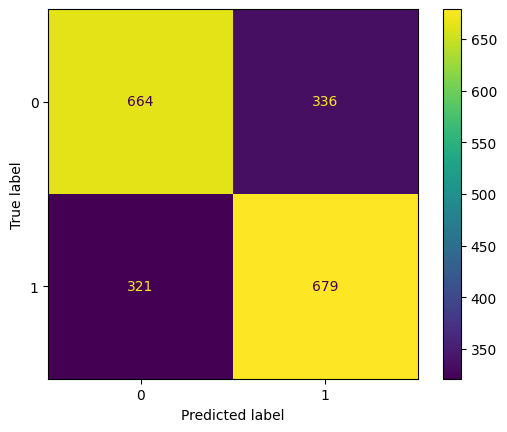

In [221]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [222]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  664
False Positive:  336
False Negative:  321
True Positive:  679


ROC Area Under the Curve:  0.6715


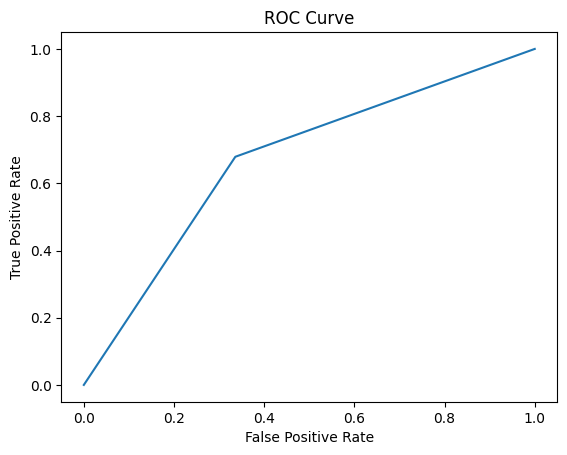

In [223]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [224]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.6739454094292804


#### Hyperparameter Tuning

In [225]:
nb_clf_under = BernoulliNB()
nb_clf_under.get_params()

{'alpha': 1.0,
 'binarize': 0.0,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': 'warn'}

In [226]:
#grid search to tune the hyperparameters

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}
nb_clf_under = GridSearchCV(nb_clf_under, param, n_jobs=-1, cv=cv)
result = nb_clf_under.fit(X_train_avg, y_train)
y_pred = nb_clf_under.predict(X_test_avg)

In [227]:
print("best hyperparameters: ", nb_clf_under.best_params_)

best hyperparameters:  {'alpha': 1.0, 'fit_prior': True}


In [228]:
# model accuracy
nb_acc = accuracy_score(y_test, y_pred)
nb_acc

0.6715

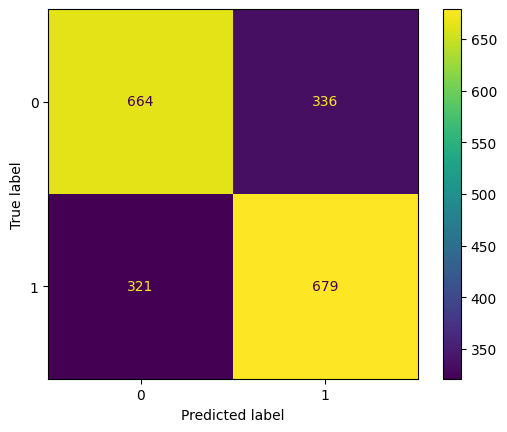

In [229]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [230]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  664
False Positive:  336
False Negative:  321
True Positive:  679


ROC Area Under the Curve:  0.6715


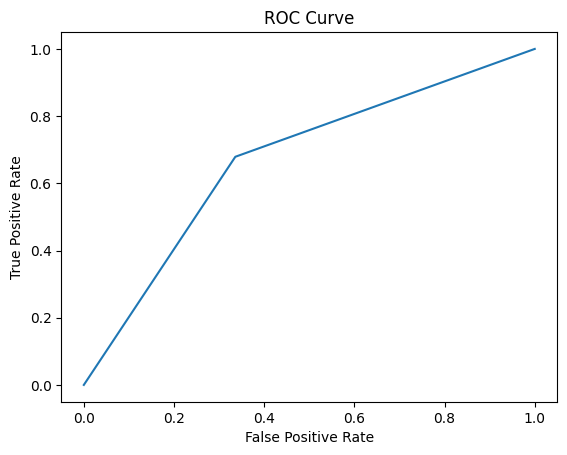

In [231]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [232]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.6739454094292804


###  Logistic Regression

In [233]:
# logistic regression fit and predict
lr_clf_under = LogisticRegression().fit(X_train_avg, y_train) 
y_pred = lr_clf_under.predict(X_test_avg)

In [234]:
# model accuracy
log_acc = accuracy_score(y_test, y_pred)
log_acc

0.749

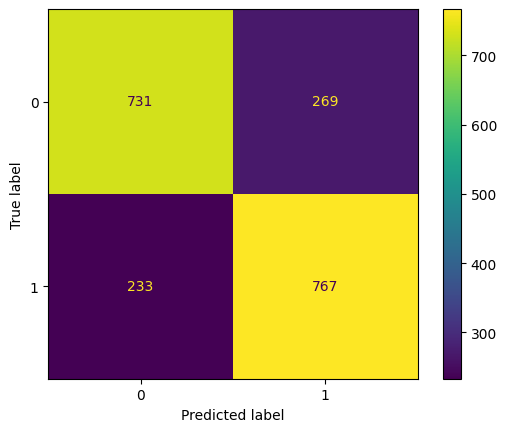

In [235]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [236]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  731
False Positive:  269
False Negative:  233
True Positive:  767


ROC Area Under the Curve:  0.749


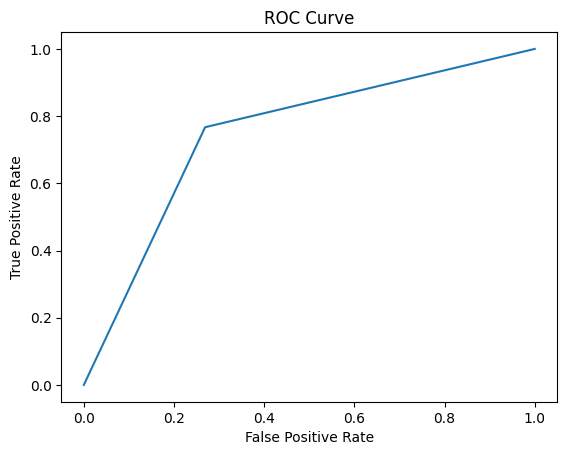

In [237]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [238]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7534381139489195


#### Hyperparameter Tuning

In [239]:
lr_clf_under = LogisticRegression()
lr_clf_under.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [240]:
#grid search to tune the hyperparameters

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'C': [0.1, 1, 10], 
    # 'penalty': ['l1', 'l2']
}
lr_clf_under = GridSearchCV(lr_clf_under, param, n_jobs=-1, cv=cv)
result = lr_clf_under.fit(X_train_avg, y_train)
y_pred = lr_clf_under.predict(X_test_avg)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [241]:
print("best hyperparameters: ", lr_clf_under.best_params_)

best hyperparameters:  {'C': 10}


In [242]:
# model accuracy
lr_acc = accuracy_score(y_test, y_pred)
lr_acc

0.747

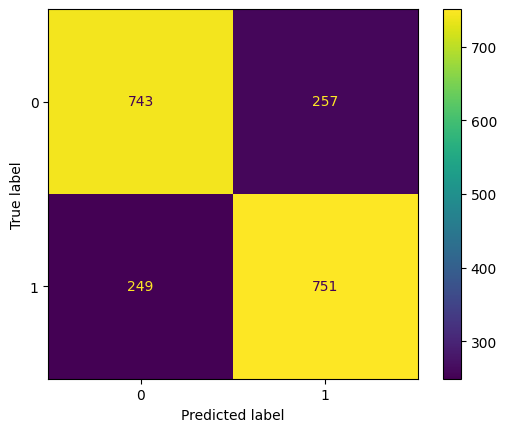

In [243]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [244]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  743
False Positive:  257
False Negative:  249
True Positive:  751


ROC Area Under the Curve:  0.7469999999999999


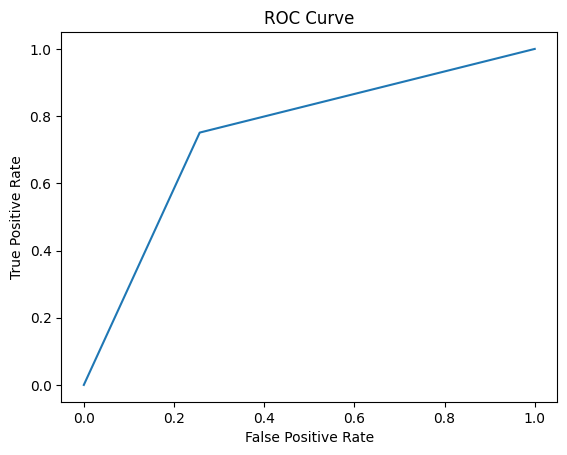

In [245]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [246]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7480079681274899


###  XGBoost

In [247]:
# xgboost fit and predict
xgb_clf_under = xgb.XGBClassifier().fit(X_train_avg, y_train) 
y_pred = xgb_clf_under.predict(X_test_avg)

In [248]:
# model accuracy
xgb_acc = accuracy_score(y_test, y_pred)
xgb_acc

0.7455

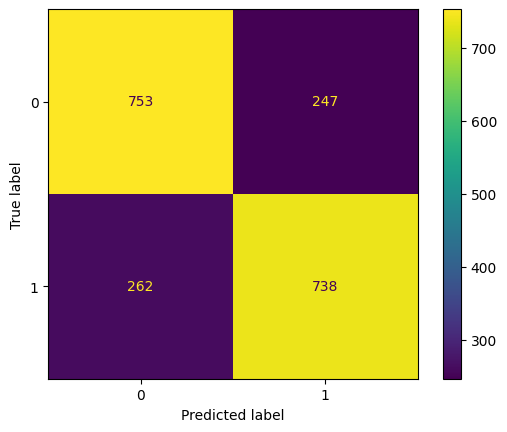

In [249]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_under.classes_)
disp.plot()

In [250]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  753
False Positive:  247
False Negative:  262
True Positive:  738


ROC Area Under the Curve:  0.7454999999999999


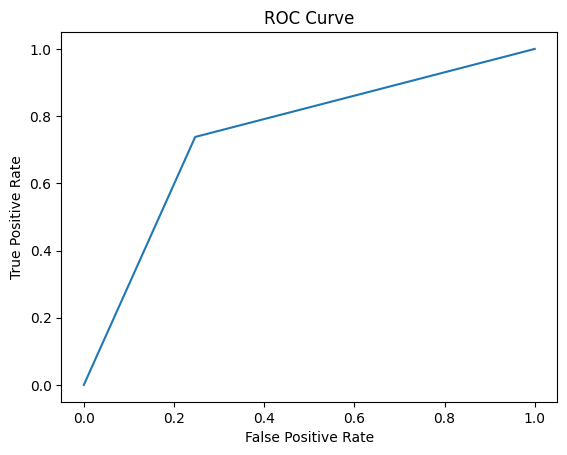

In [251]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [252]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7435768261964736


# Dataset Shift - Glove

In [ ]:
if not os.path.exists("/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv"):
  !gdown 1UC7svIwq3ZDwI1sxZoTU7s7qmgKABuXp

Downloading...
From: https://drive.google.com/uc?id=1UC7svIwq3ZDwI1sxZoTU7s7qmgKABuXp
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 72.5MB/s]


In [ ]:
movies_df = pd.read_csv('/content/IMDB Dataset.csv')

In [51]:
movies_df = pd.read_csv('/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv')

In [52]:
movies_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


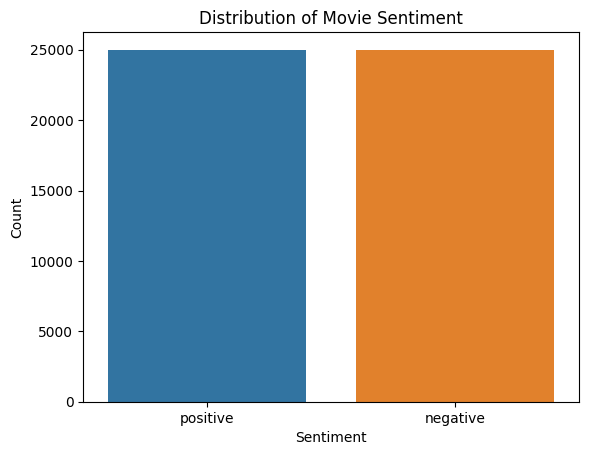

In [53]:
sns.countplot(x=movies_df.sentiment)
plt.xlabel('Sentiment')
plt.ylabel("Count")
plt.title("Distribution of Movie Sentiment")
plt.show()

## Preprocessing

## Testing the models on the movie dataset


In [54]:
movies_df.shape

(50000, 2)

In [55]:
movies_df = movies_df[movies_df['review'].notna()]

In [56]:
movies_df = movies_df[movies_df['review'].apply(lambda x: len(x.split()) != 0)]

In [57]:
NUMBERS_RE = re.compile('[^0-9]+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [58]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    result = re.match(r"[0-9]+", text)
    if result != None:
      text = NUMBERS_RE.sub('X', text)

    text = text.replace('X', '')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

movies_df['review'] = movies_df['review'].apply(clean_text)

In [59]:
movies_df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [60]:
s0 = movies_df.sentiment[movies_df.sentiment.eq("positive")].sample(600).index
s1 = movies_df.sentiment[movies_df.sentiment.eq("negative")].sample(600).index 

movies_df_sub = movies_df.loc[s0.union(s1)]

In [61]:
movies_df_sub['sentiment'].value_counts()

positive    600
negative    600
Name: sentiment, dtype: int64

In [62]:
y = np.where(movies_df_sub['sentiment']=='positive', 1, 0)
y

array([1, 0, 1, ..., 0, 0, 1])

In [63]:
X = movies_df_sub['review']
X

14       fantastic movie three prisoners become famous ...
84       brought film joke friend could worst joke play...
193      feeling mislike russian films seeing film have...
241      feel niiiiiight heat feel heeaaaaaaaaaartbeat ...
256      saw movie middle night flipping channels nothi...
                               ...                        
49777    movie beyond horrible avoid costs want hour 20...
49803    nothing cool hip clever film liking reveals ig...
49814    gates hell opened spit film closed againbr br ...
49923    seems companies enjoy taxes taken romania pict...
49930    read comments film still amazed foxs reluctanc...
Name: review, Length: 1200, dtype: object

In [64]:
# Trunc/Pad X_train and y_train
MAX_LEN = 50 # As the mean is 41
X = trunc_pad(X, MAX_LEN)

In [67]:
sent_vectors_train = np.zeros((len(X), MAX_LEN, vocab_class.embed))
i = 0
for sentence in tqdm(X):
    sentence_vector = get_embedding_sentence(sentence, vocab_class)
    sent_vectors_train[i] = sentence_vector
    i += 1

100%|██████████| 1200/1200 [00:50<00:00, 23.81it/s]


In [68]:
X = sent_vectors_train
X.shape

(1200, 50, 300)

In [69]:
X = np.mean(X, axis=1)

In [70]:
X.shape

(1200, 300)

In [86]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'
np.save(f'{path}/dataset_shift_X_glove_1200', X)
np.save(f'{path}/dataset_shift_y_glove_1200', y)

### Naive Bayes

In [71]:
# naive bayes predict
y_pred = nb_clf_under.predict(X)
# model accuracy
nb_acc = accuracy_score(y, y_pred)
print("Accuracy for Naive Bayes: ", nb_acc)

Accuracy for Naive Bayes:  0.6666666666666666


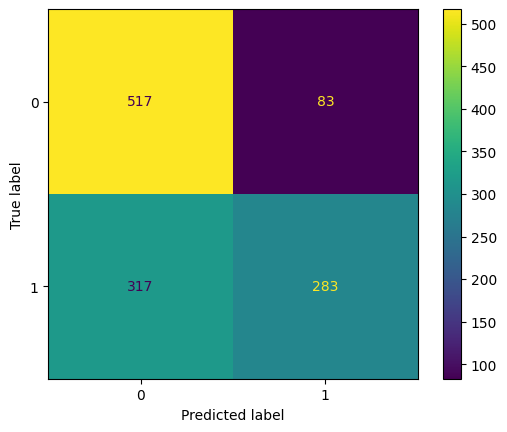

In [72]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [73]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  517
False Positive:  83
False Negative:  317
True Positive:  283


ROC Area Under the Curve:  0.6666666666666667


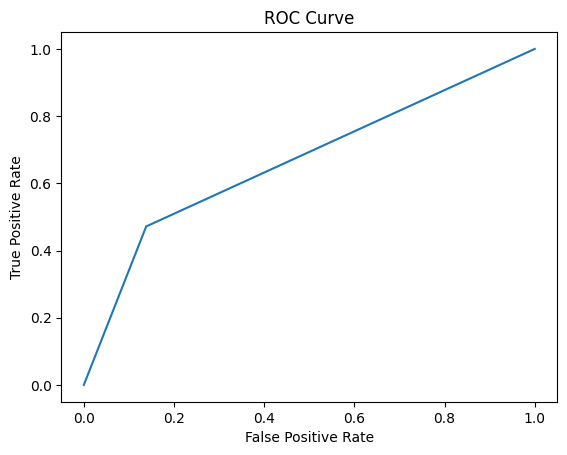

In [74]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [75]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.58592132505176


### Logistic Regression

In [76]:
# logistic regression predict
y_pred = lr_clf_under.predict(X)
# model accuracy
lr_acc = accuracy_score(y, y_pred)
print("Accuracy for Logistic Regression: ", lr_acc)

Accuracy for Logistic Regression:  0.7041666666666667


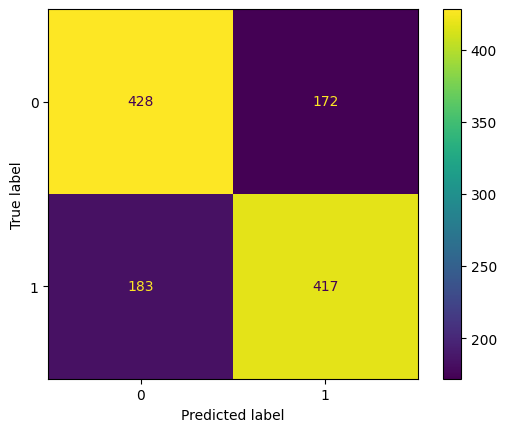

In [77]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [78]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  428
False Positive:  172
False Negative:  183
True Positive:  417


ROC Area Under the Curve:  0.7041666666666667


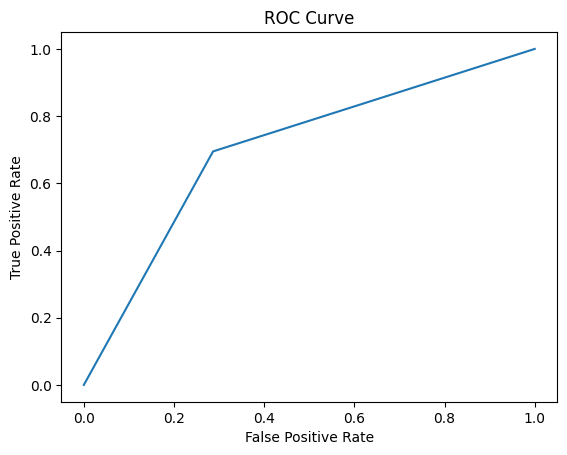

In [79]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [80]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.7014297729184189


### XGBoost

In [81]:
# xgboost predict
y_pred = xgb_clf_under.predict(X)
# model accuracy
xgb_acc = accuracy_score(y, y_pred)
print("Accuracy for XGBoost: ", xgb_acc)

Accuracy for XGBoost:  0.6758333333333333


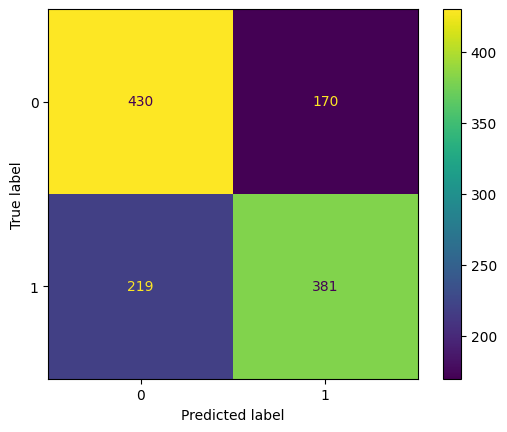

In [82]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=xgb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_under.classes_)
disp.plot()

In [83]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  430
False Positive:  170
False Negative:  219
True Positive:  381


ROC Area Under the Curve:  0.6758333333333334


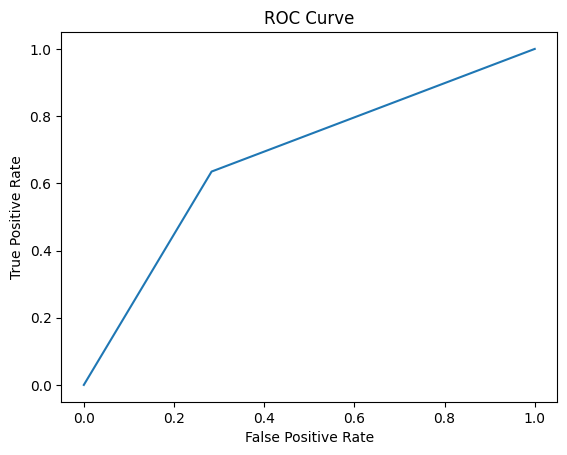

In [84]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [85]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.6620330147697654


# Dataset Shift - W2V

In [ ]:
if not os.path.exists("/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv"):
  !gdown 1UC7svIwq3ZDwI1sxZoTU7s7qmgKABuXp

Downloading...
From: https://drive.google.com/uc?id=1UC7svIwq3ZDwI1sxZoTU7s7qmgKABuXp
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 72.5MB/s]


In [ ]:
movies_df = pd.read_csv('/content/IMDB Dataset.csv')

In [134]:
movies_df = pd.read_csv('/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv')

In [135]:
movies_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


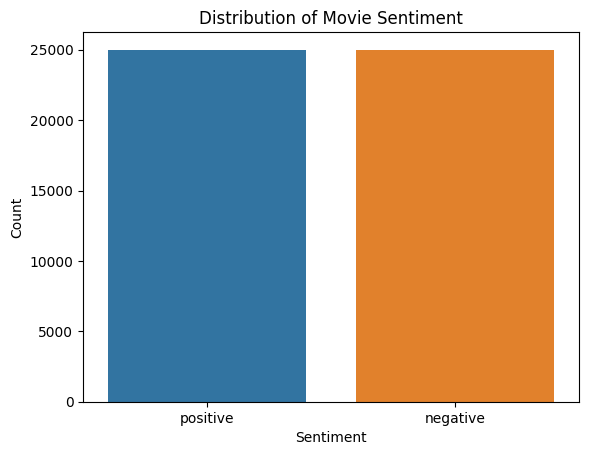

In [136]:
sns.countplot(x=movies_df.sentiment)
plt.xlabel('Sentiment')
plt.ylabel("Count")
plt.title("Distribution of Movie Sentiment")
plt.show()

## Preprocessing

## Testing the models on the movie dataset


In [133]:
movies_df.shape

(50000, 2)

In [137]:
movies_df = movies_df[movies_df['review'].notna()]

In [138]:
movies_df = movies_df[movies_df['review'].apply(lambda x: len(x.split()) != 0)]

In [139]:
NUMBERS_RE = re.compile('[^0-9]+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [140]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    result = re.match(r"[0-9]+", text)
    if result != None:
      text = NUMBERS_RE.sub('X', text)

    text = text.replace('X', '')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

movies_df['review'] = movies_df['review'].apply(clean_text)

In [141]:
movies_df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [142]:
s0 = movies_df.sentiment[movies_df.sentiment.eq("positive")].sample(600).index
s1 = movies_df.sentiment[movies_df.sentiment.eq("negative")].sample(600).index 

movies_df_sub = movies_df.loc[s0.union(s1)]

In [143]:
movies_df_sub['sentiment'].value_counts()

positive    600
negative    600
Name: sentiment, dtype: int64

In [144]:
y = np.where(movies_df_sub['sentiment']=='positive', 1, 0)
y

array([1, 0, 1, ..., 1, 1, 1])

In [145]:
X = movies_df_sub['review']
X

2        thought wonderful way spend time hot summer we...
70       caddyshack two good movie compared original ca...
102      bought game impulse buy walmart glad entertain...
124      tale based two edgar allen poe pieces fall hou...
197      scotty grant cramer would go star great bmovie...
                               ...                        
49769    ive fan jim henson characters since beginning ...
49797    yeah bought camp blood wasted 86 minutes life ...
49835    first saw film video department store intrigue...
49888    1955 five years one released james stewart ant...
49985    imaginary heroes clearly best film year comple...
Name: review, Length: 1200, dtype: object

In [146]:
# Trunc/Pad X_train and y_train
MAX_LEN = 50 # As the mean is 41
X = trunc_pad(X, MAX_LEN)

In [147]:
sent_vectors_train = np.zeros((len(X), MAX_LEN, vocab_class.embed))
i = 0
for sentence in tqdm(X):
    sentence_vector = get_embedding_sentence(sentence, vocab_class)
    sent_vectors_train[i] = sentence_vector
    i += 1

100%|██████████| 1200/1200 [02:25<00:00,  8.26it/s]


In [148]:
X = sent_vectors_train
X.shape

(1200, 50, 300)

In [149]:
X = np.mean(X, axis=1)

In [150]:
X.shape

(1200, 300)

In [151]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'
np.save(f'{path}/dataset_shift_X_W2V_1200', X)
np.save(f'{path}/dataset_shift_y_W2V_1200', y)

### Naive Bayes

In [152]:
# naive bayes predict
y_pred = nb_clf_under.predict(X)
# model accuracy
nb_acc = accuracy_score(y, y_pred)
print("Accuracy for Naive Bayes: ", nb_acc)

Accuracy for Naive Bayes:  0.5008333333333334


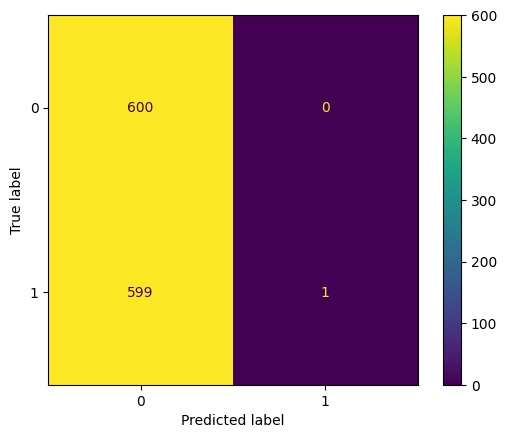

In [153]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [154]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  600
False Positive:  0
False Negative:  599
True Positive:  1


ROC Area Under the Curve:  0.5


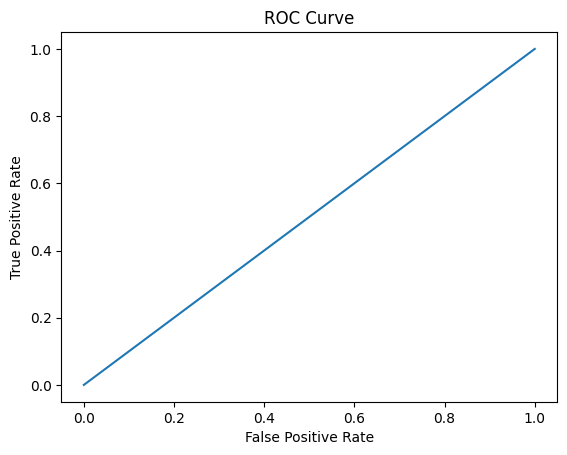

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [155]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.0033277870216306157


### Logistic Regression

In [156]:
# logistic regression predict
y_pred = lr_clf_under.predict(X)
# model accuracy
lr_acc = accuracy_score(y, y_pred)
print("Accuracy for Logistic Regression: ", lr_acc)

Accuracy for Logistic Regression:  0.495


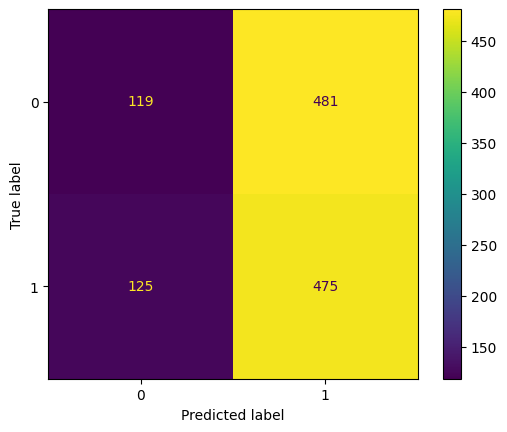

In [157]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [158]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  119
False Positive:  481
False Negative:  125
True Positive:  475


ROC Area Under the Curve:  0.495


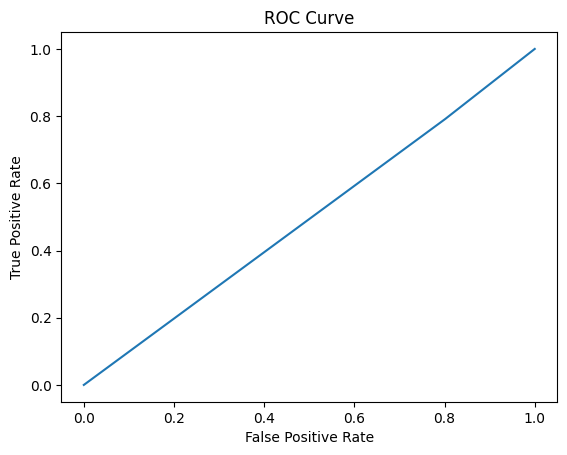

In [159]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [160]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.6105398457583547


### XGBoost

In [161]:
# xgboost predict
y_pred = xgb_clf_under.predict(X)
# model accuracy
xgb_acc = accuracy_score(y, y_pred)
print("Accuracy for XGBoost: ", xgb_acc)

Accuracy for XGBoost:  0.49166666666666664


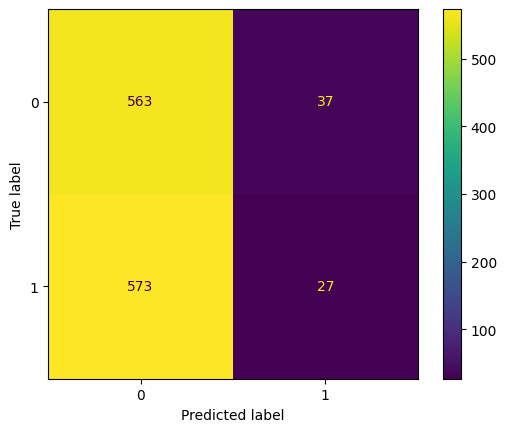

In [162]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=xgb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_under.classes_)
disp.plot()

In [163]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  563
False Positive:  37
False Negative:  573
True Positive:  27


ROC Area Under the Curve:  0.49166666666666664


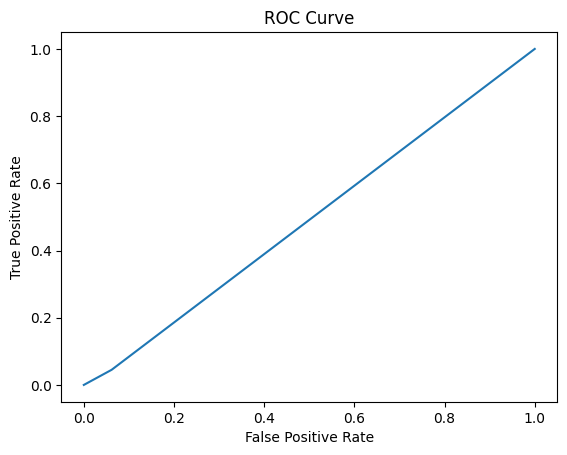

In [164]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [165]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.08132530120481928


# Save Models

In [ ]:
import os
import joblib

In [ ]:
path = "/content/drive/MyDrive/CIS5190-Project/Work/Models"

In [ ]:
filename = "nb_model.pkl"
if not os.path.exists(path):
    os.makedirs(path)
joblib.dump(nb_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/nb_model.pkl']

In [ ]:
filename = "lr_model.pkl"
if not os.path.exists(path):
    os.makedirs(path)
joblib.dump(lr_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/lr_model.pkl']

In [ ]:
filename = "xgb_model.pkl"
if not os.path.exists(path):
    os.makedirs(path)
joblib.dump(xgb_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/xgb_model.pkl']